# <font color='deeppink'><b> Actor-Critic in Reinforcement Learning </b></font>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical
import random
import gym
import time 
import numpy as np
import torchplot as tp
from itertools import count
from collections import namedtuple
from circuit.vcamp import VCAmpRLEnvDiscrete
import math
from torch.optim.lr_scheduler import StepLR

# Plots 
import matplotlib.pyplot as plt

# Setting a fixed seed for reproducible results
np.random.seed(seed=12)
torch.manual_seed(seed=12)


#import pygame
#from pygame import gfxdraw

<string>:2: DeprecationWarning: invalid escape sequence \m
<string>:2: DeprecationWarning: invalid escape sequence \ 
<string>:2: DeprecationWarning: invalid escape sequence \l
<string>:2: DeprecationWarning: invalid escape sequence \s


In [2]:
# Create the environment
env = VCAmpRLEnvDiscrete()

c:\Users\tomas\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

In [4]:
print("There are {} actions".format(env.action_size))
print(env.reset().shape)


There are 60 actions
(23,)


# <font color='orangered'><b> Model Network </b></font>

In [5]:
# Network: Actor-Critic 
#     
# First fully connected layer with 23 inputs (states) and 256 outputs (arbitrary number)
# 


class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.common1 = torch.nn.Linear(23, 1024) # x because there are x parameters as the observation space
        self.common2 = torch.nn.Linear(1024, 512)
        
        self.actor = torch.nn.Linear(512, 60) # 72 for the number of actions

        # self.fc3 = torch.nn.Linear(128,20)
        self.critic = torch.nn.Linear(512, 1) # Critic is always 1
        
        self.saved_actions = []
        self.rewards = []
        
    def forward(self, x):
                #print(f"{x= }")
        #print(f"{action_scores= }")

        x = F.leaky_relu(self.common1(x))
        x = F.leaky_relu(self.common2(x))        

        action_scores = torch.sigmoid(self.actor(x))
        

        action_prob = F.softmax(action_scores, dim=-1)

        # x = torch.sigmoid(self.fc3(x))
        state_values = self.critic(x)
        # state_values = F.softmax(state_values)
        # print(f"{state_values= }")
        
        
        return action_prob, state_values
       

# <font color='indianred'><b> New Model Network </b></font>

In [6]:
class ActorCritic_new(nn.Module):
    def __init__(self):
        super(ActorCritic_new, self).__init__()

        self.saved_actions = []
        self.rewards = []

        self.critic = nn.Sequential(
            nn.Linear(23, 1024),
            nn.ELU(),
            nn.Linear(1024, 512),
            nn.ELU(),
            nn.Linear(512,1)
        )

        self.actor = nn.Sequential(
            nn.Linear(23, 1024),
            nn.ELU(),
            nn.Linear(1024, 512),
            nn.ELU(),
            nn.Linear(512, 36),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        state_values = self.critic(x)
        action_probs = self.actor(x)

        return action_probs, state_values


In [7]:
action_space_size = env.action_size
state_space_size = env.obs.shape[0]

# Lists for plotting
episode_list = []
reward_list = []
loss_list = []
policy_loss_list = []
value_loss_list = []


# <font color='violet'><b> Specifications </b></font>

In [8]:
learning_rate = 1e-4

model = ActorCritic()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Adaptive Learning Rate
scheduler = StepLR(optimizer, step_size=2, gamma=0.2)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [9]:
# lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len( dataloaders["train"])))
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# <font color='crimson'><b> Action Selection </b></font>

In [10]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model.forward(state)

    # flag = random()
  
    # exploration_rate_threshold = random.uniform(0,1)
    # print(len(probs), len(state_value))

    # print(state)
    # print(probs)

    # probs = math.log(probs)

    m = Categorical(probs)
 
    action = m.sample()

    # print("Action: " , action)   


    # else:
    # while action.item() != 1 and action.item() != 3 and action.item() != 5\
    #         and action.item() != 7 and action.item() != 12 and action.item() != 14 \
    #              and action.item() != 21 and action.item() != 26 and action.item() != 27 :
    #     print(action.item())
    #     action = torch.tensor(env.sample_action())
        # print(action.item())


    # perform one action and assess the results

    # action = torch.tensor(env.sample_action())
    # print(action)
    
    # print("Chosen Action: ", action.item())


    # print(action.item())
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    
    return action.item()


# <font color='scarlet'><b> Finish Episode condition</b></font>

In [11]:
from importlib.metadata import entry_points


def finish_episode():
    
    # We calculate the losses and perform backprop in this function
    R = 0
    policy_losses = []
    value_losses = []
    #entropy_losses = []
    beta = 1e-3
    saved_actions = model.saved_actions
    returns = []
    gamma = 0.99 #Discount factor for past rewards
    

    # Calculate expected value from rewards
    # - At each timestep what's the total reward received after that timestep
    # - Rewards in the past are discounted by multiplying them with gamma
    # - These are the labels for our critic
    # - R: Past Rewards
    # - r: total Reward
    for r in model.rewards[::-1]:
        R = r + gamma * R 
        returns.insert(0, R)
        # print(returns)


    # R é return real
    # value é o retorno do crítico


    if len(returns) <= 1:
        returns = torch.tensor([0.0])
        
    # Normalize
    else: 
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

    # print("model rewards" , model.rewards)
    # print("Returns " , returns)
    # print("Saved action" ,saved_actions)


    # Critic train
    for (log_prob, value), R in zip(saved_actions, returns):
        # At this point in history, the critic estimated that we would get a
        # total reward = `value` in the future. We took an action with log probability
        # of `log_prob` and ended up recieving a total reward = `ret`.
        # The actor must be updated so that it predicts an action that leads to
        # high rewards (compared to critic's estimate) with high probability.
        advantage = R - value.item()
        # print("advantage: ", advantage)
        
       # entropy_loss = -beta * (action_probs * log_prob).sum(dim=1).mean()   
        policy_losses.append(-log_prob * advantage)
        # Actor Loss
        policy_loss_list.append(policy_losses)
        

        # The critic must be updated so that it predicts a 
        # better estimate of future rewards.
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))
        value_loss_list.append(value_losses)
        # print("Log_prob: ", log_prob)


    # Sets the gradients to zero before performing backpropagation because pytorch accumulates the gradients
    optimizer.zero_grad()

    # BackPropagation
    # loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # print("Policy loss: ", policy_losses)
    # print("Value loss: ", value_losses)
    # print("Total Loss", loss)
    loss_list.append(loss)
    loss.backward()
    
    # Gradient Clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm= 1)
    
    # print("----------------------------------------------------------GRADIENTS-----------------------------------------------\n")
    # for p in model.parameters():
        #print(p.grad.norm())
        #print(loss)



    optimizer.step()
    scheduler.step()
    print("LR = ", scheduler.get_last_lr())

    
    # Clear the loss and reward history
    # del model.rewards[:]
    # del model.saved_actions[:]


In [12]:
# epochs=30
# lrs=[]
# for epoch in range(1,epochs+1):
#   train(model,optimizer,epoch,1000)
#   scheduler.step()

# <font color='darkorange'><b> Plots </b></font>

In [13]:
# Pretty Colors for plots

Colors = ['mediumaquamarine', 'blueviolet', 'lightcoral',
            'darkorange', 'royalblue', 'crimson', 'dimgray',
            'navy', 'violet', 'teal', 'hotpink', 'peru']


In [14]:
def plot_reward(episode_list, reward_list, intervals=None):
  
    n_ep = len(episode_list)

    if intervals is None:
        intervals = [[0, n_ep]]

    for i, [l, r] in enumerate(intervals):
        plt.plot(episode_list[max(0,l):min(r,n_ep)], reward_list[max(0,l):min(r,n_ep)], color=Colors[i])
        print(l, r)
    
    plt.xlabel('x - # Episode')
    plt.ylabel('y - Reward')
    plt.title('Reward over episodes')
    # plt.xscale('log')
    # plt.xscale('log')
    plt.grid()
    plt.show()

In [15]:
def plot_losses(episode_list, loss_list):

    tp.plot(episode_list, loss_list)
    tp.xlabel('x - # Episode')
    tp.ylabel('y - Loss')
    tp.title('Total Losses over episodes')
    tp.grid()
    tp.show()

In [16]:
def plot_policy_losses(episode_list, policy_loss_list):

    tp.plot(episode_list, policy_loss_list)
    tp.xlabel('x - # Episode')
    tp.ylabel('y - Loss')
    tp.title('Policy Losses over episodes')
    tp.grid()
    tp.show()

In [17]:
def plot_value_losses(episode_list, value_loss_list):

    tp.plot(episode_list, value_loss_list)
    tp.xlabel('x - # Episode')
    tp.ylabel('y - Loss')
    tp.title('Value Losses over episodes')
    tp.grid()
    tp.show()

# <font color='gold'><b> Training </b></font>

In [18]:
def train():
    running_reward = -1
    episode_list = []
    reward_list = []
    t_max = 50
        # cnt_up = 0


    for i_episode in count(): # We need around this much episodes
        state = env.reset(env.values_init)
        ep_reward = 0
        reward_improvement = 0 
        # print(state)
        # print(probs)

       

        for t in range(1, t_max):
            # print(t, end=', \n')
        
            action = select_action(state)                   # Action is selected
            state, reward, done, log = env.step(action)     # State is updated accordingly

            print("reward: ",reward)
            print("action: ",action)


            # model.rewards.append(reward)
            # print(model.rewards)
            # if i_episode > 0:
            #     if model.rewards[t-2] < model.rewards[t-1]:
            #             reward_improvement = model.rewards[t-1] - model.rewards[t-2]
            #             cnt_up += 1
            #             print("# Action:",action, "Improvement:", reward_improvement)

                # elif model.rewards[t-2] > model.rewards[t-1]:
                #     reward_improvement = model.rewards[t-1] - model.rewards[t-2]
                #     print("# Action:",action, "Piorou:", reward_improvement)

            # se nao houver improvement - fazer unstep

            ep_reward = reward
        

            
            if done:
                break
        
        
        # print("nºde melhoramentos: ", cnt_up )

        # Breaking conditions in case it does not find a solution that fits the requirements
        if i_episode == 200:
            break


        # Update running reward to check condition for solving
        running_reward = 0.05 * ep_reward + (1-0.05) * running_reward


        # Additional lists for plotting
        episode_list.append(i_episode)
        reward_list.append(ep_reward) 


        finish_episode()


        # print("learning rate = ", learning_rate)
        # finish_episode()
        # finish_episode()
        # finish_episode()
        # finish_episode()
        del model.rewards[:]
        del model.saved_actions[:]


        # exploration_rate = min_exploration_rate + \
            # (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*i_episode)




        if i_episode % 1 == 0: #% 2 == 0: # We will print some things out
            print("------------------------Episode {}\tLast Reward: {:.3f}\tRunning reward: {:.3f}---------------------------------------------\n".format(
                i_episode, ep_reward, running_reward
            ))
            
        if running_reward >= 0:
            print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
                    running_reward, t
            ))
            print("log: ", log)

            break
           
    plot_reward(episode_list, reward_list, [[0,100],[99,300],[299,500],[499,1000],[999,1500],[1499,3000],[2999,4000],[3999,5000],[4999,6000]])
    # plot_reward(episode_list, reward_list,[[0,100],[99,300],[299,500],[499,1000],[999,1500],[1499,3000],[2999,4000],[3999,5000]] )
    plot_reward(episode_list, reward_list,[[0,15]] )   
    plot_reward(episode_list, reward_list,[[15,30]] )
    plot_losses(episode_list[0:i_episode], loss_list)
    plot_policy_losses(episode_list, policy_loss_list)
    plot_value_losses(episode_list, value_loss_list)

        
    # plot_value_losses(episode_list, value_losses)
   

reward:  -2.9087135392833092
action:  17
reward:  -2.908134060247965
action:  54
reward:  -2.9063836372107024
action:  56
reward:  -5.544268411267001
action:  0
reward:  -5.683137163654926
action:  28
reward:  -5.745855010184855
action:  36
reward:  -3.0637190711727724
action:  43
reward:  -3.2791039424478083
action:  13
reward:  -5.001694903587351
action:  30
reward:  -4.956227766178329
action:  48
reward:  -5.1824987522063575
action:  20
reward:  -100
action:  7
LR =  [0.0001]
------------------------Episode 0	Last Reward: -100.000	Running reward: -5.950---------------------------------------------

reward:  -1.56008334736888
action:  49
reward:  -1.4101520306887108
action:  44
reward:  -1.5471599754657284
action:  7
reward:  -1.538189766599786
action:  57
reward:  -0.9199437531311732
action:  16
reward:  -0.920043567315047
action:  37
reward:  -2.978445312458276
action:  0
reward:  -3.197254325858861
action:  7
reward:  -3.4818051591494252
action:  40
reward:  -1.1918160731213252
ac

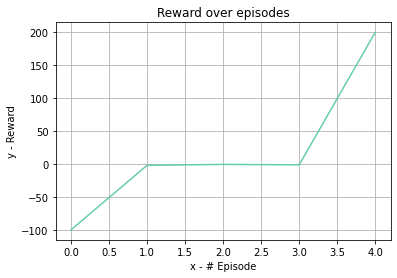

0 15


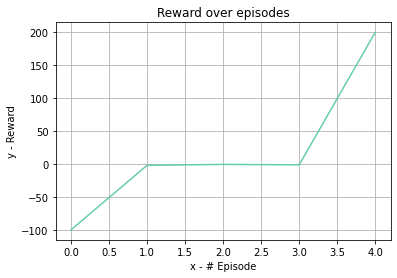

15 30


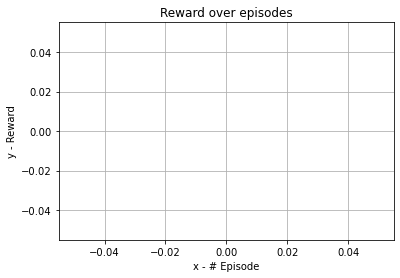

ValueError: x and y must have same first dimension, but have shapes (4,) and (5,)

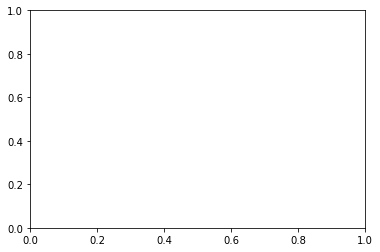

In [19]:
train()

In [ ]:
env._run_simulation()
env.measures

{'gdc': 56.3238,
 'gbw': 91013380.0,
 'pm': 33.88136,
 'inoise_total': 7.989457e-05,
 'onoise_total': 0.01426119,
 'output': '6.330460600167953e-09',
 'in_p': '1.650000000000000e+00',
 'in_n': '1.650000000000000e+00',
 'm_xinova_mpm0_vgs': '1.487481375938065e+00',
 'm_xinova_mpm0_vth': '4.467744351473703e-01',
 'm_xinova_mpm0_vds': '1.368007369281312e+00',
 'm_xinova_mpm0_vdsat': '8.590845564373085e-01',
 'm_xinova_mpm0_id': '2.189033768289443e-04',
 'm_xinova_mpm1_vgs': '1.487481376285776e+00',
 'm_xinova_mpm1_vth': '4.467900041923248e-01',
 'm_xinova_mpm1_vds': '1.487481376298448e+00',
 'm_xinova_mpm1_vdsat': '8.591949120481036e-01',
 'm_xinova_mpm1_id': '4.192451447262043e-05',
 'm_xinova_mpm2_vgs': '1.487481376449405e+00',
 'm_xinova_mpm2_vth': '4.467900041923213e-01',
 'm_xinova_mpm2_vds': '1.487481376460569e+00',
 'm_xinova_mpm2_vdsat': '8.591949121753241e-01',
 'm_xinova_mpm2_id': '4.192451448302894e-05',
 'm_xinova_mpm3_vgs': '1.487481376100185e+00',
 'm_xinova_mpm3_vth': '4.46

In [ ]:
# There. we finished
# Lets see it in action
done = False
cnt = 0

In [ ]:
observation = env.reset()
while True:
    cnt += 1
    env.render()
    action = select_action(observation)
    observation, reward, done, _ = env.step(action)
    # Lets see how long it lasts until failing
print(f"Game lasted {cnt} moves")

Values:
 [ 9.4e-05  8.5e-05  1.0e-06  5.3e-05  5.6e-05  4.9e-05  7.8e-06  1.9e-06
  7.7e-06  5.0e-07  1.6e-06  1.5e-06  1.0e+00  4.0e+00  4.0e+00 -1.0e+00
  5.0e+00  4.0e+00]
Performance: -12.279758991513848
Eval Log: {'idd_lt': (0.00035, 0.004192434062029847), 'gdc_gt': (50, 33.57578), 'gbw_gt': (35000000.0, 948795.5)}
Values:
 [ 9.4e-05  8.5e-05  1.0e-06  5.3e-05  5.6e-05  4.9e-05  7.8e-06  1.9e-06
  7.7e-06  5.0e-07  1.6e-06  1.5e-06  1.0e+00  4.0e+00  4.0e+00 -2.0e+00
  5.0e+00  4.0e+00]
Performance: -12.279758991513848
Eval Log: {'idd_lt': (0.00035, 0.004192434062029847), 'gdc_gt': (50, 33.57578), 'gbw_gt': (35000000.0, 948795.5)}
Values:
 [ 9.4e-05  8.5e-05  1.0e-06  5.3e-05  5.6e-05  4.9e-05  7.8e-06  1.9e-06
  7.7e-06  6.0e-07  1.6e-06  1.5e-06  1.0e+00  4.0e+00  4.0e+00 -2.0e+00
  5.0e+00  4.0e+00]
Performance: -12.27474503546729
Eval Log: {'idd_lt': (0.00035, 0.004192434062029847), 'gdc_gt': (50, 33.57578), 'gbw_gt': (35000000.0, 948795.5)}
Values:
 [ 9.4e-05  8.5e-05  1.0e-0